<h1> Ads conversion predicition: </h1>

<h2>1.Introduction</h2>

The goal of the notebook is to Predict who is likely going to convert after seeing an impression based on impression and user features. 

classes Implementation:

In [2]:
import json
import datetime
import pandas as pd

class Impression(object):
    """
    Class to simplify interacting with an impression log.
    """
    def __init__(self, log):
        """
        Parameters
        ----------
        log:dict
            A single row of the impression log file.
        """
        self._log=log
        self.uuid=log.get('uuid')
        self.timestamp=log.get('ts')
        #get the timestamp and convert it to python datetime object
        self.date=datetime.datetime.fromtimestamp(self.timestamp)
        self.dev_app=log.get('dev').get('app')
        self.dev_os=log.get('dev').get('os')
        self.dev_sid=log.get('dev').get('sid')
        self.resp_c=log.get('resp').get('c')
        self.resp_cr=log.get('resp').get('cr')
        self.resp_oi=log.get('resp').get('oi')
        self.conv=log.get('conv')
        
    def didConvert(self):
        return bool(self._log('conv'))
    
  
    def getLogAttributes(self):
        """ return the single row of the impression
        log attribute as a list
        """
        return [self.uuid,self.dev_app,self.dev_os,self.dev_sid,self.resp_c,self.resp_cr,self.resp_oi,self.date,self.conv]

def getAllData(campaign_impressions_path,user_segments_path):
    """
    convert campaign_impressions.json and user_segments.csv to dataframe
    parameters: campaign impression file path , user segments file path
    return campaign impression dataframe, user segments dataframe
    """
    
    data = []
    for line in open(campaign_impressions_path, 'r',encoding="utf-8"):
        data.append(json.loads(line))
    row = ['uuid', 'dev_app', 'dev_os','dev_sid','resp_c','resp_cr','resp_oi','timestamp','conv']
    dataf=list()
    for i in range(len(data)):
        row=Impression(data[i]).getLogAttributes()
        dataf.append([row[j] for j in range(len(row)) ])
    df_camp_imp= pd.DataFrame(dataf, columns=[ 'uuid','dev_app', 'dev_os','dev_sid','resp_c','resp_cr','resp_oi','timestamp','conv'])
    df_user_segments=pd.read_csv(user_segments_path)
    df_user_segments.rename( columns={'Unnamed: 0':'USER_ID'}, inplace=True )
    df_user_segments=df_user_segments.astype(int)
    df_camp_imp.uuid=df_camp_imp.uuid.astype(int)
    return df_camp_imp,df_user_segments 


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


class Information(object):
    """
    This class give some information about the datasets
    """
    
    def __init__(self):
        """not required any Parameters"""
        
    def convDistribution(self,train):
        """
        display the distribution of the target
        """
        sns.countplot(x='conv',data=train, palette='hls')
        plt.show();
        print('')
        print(train.conv.value_counts()/len(train))
        
    def featureDistribution(self,train,feature):
        """
        display the distribution of a given feature
        """
        print('distribution of the feature {} :\n'.format(feature) )
        print(train[feature].value_counts()/len(train))
    
    def plotImpressionConvDistribution(self,train,feature):
        train.groupby([feature, 'conv']).size().unstack().plot(kind='bar', figsize=(12,6), title='{} histogram'.format(feature));


    
    def histVisualize(self,train,feature):  
        """
        this method aims to visualize the CTR for each class of the feature
        """
        self.featureDistribution(train,feature)
        self.plotImpressionConvDistribution(train,feature)
        df_conv = train[train['conv'] == 1]
        df_feature = train[[feature,'conv']].groupby([feature]).count().reset_index()
        df_feature = df_feature.rename(columns={'conv': 'impressions'})
        df_feature['conv'] = df_conv[[feature,'conv']].groupby([feature]).count().reset_index()['conv']
        df_feature['CTR'] = df_feature['conv']/df_feature['impressions']*100
        feature_values = train[feature].unique()
        feature_values.sort()
        print('\nclick through rate for each class of the feature {} :\n'.format(feature))
        for i in feature_values:
            print("for value: {},  click through rate: {} %".format(i,df_feature[df_feature[feature]==i]['CTR'].values[0]))

        plt.figure(figsize=(12,6))
        sns.barplot(y='CTR', x=feature, data=df_feature)
        plt.title('CTR by {}'.format(feature));

In [9]:

class PreprocessingData(object):
    """this class preprocess the data given"""
    
    def __init__(self,df_campaign_impressions,df_user_segments,strategy):
        """parameters: paths of the data to work with, strategy : 
        {0: drop the row where we have resp_cr missing values
        1: fill the resp_cr missing value with new id value } """
        self.df_camp_imp=df_campaign_impressions
        self.df_user_segments=df_user_segments
        self.strategy=strategy
        self.addColumnHour()
        self.dealWithMissingValueCr()
        self.dropRespoiTimestamp()
        
    def makeEqualDist(self,data):
        """
        this method make the distribution of the target (conv) uniformally distributed
        Parameters: data
        Input type: dataframe
        return dataframe
        """
        data_0=data[data['conv']==0]
        data_1=data[data['conv']==1]
        data_1=data[data['conv']==1].iloc[:min(len(data_0),len(data_1))]
        data_0=data[data['conv']==0].iloc[:min(len(data_0),len(data_1))]
        data_dis_equ=data_1.append(data_0,ignore_index=True)
        return data_dis_equ

    
    def getPreprocessedData(self):
        """
        return dataframe data
        """
        return self.df_camp_imp,self.df_user_segments    

    def joinImpSegOnUUID(self,Imp,user):
        #joining the user_segments with campaign_impression on user_ide
        data=Imp.join(user,on='uuid',how='outer').drop('USER_ID',axis=1)
        return data
    
    def dealWithMissingValueCr(self):
        """
        this method deals with the resp_cr missing value
        the first strategy is to drop all the row that has
        missing value.(the missing value is just 6% of the data)
        the second strategy is to assign them a new id (for example 11)
        """
        if self.strategy==0:
            self.df_camp_imp=self.df_camp_imp.dropna()
        else:
            self.df_camp_imp=self.df_camp_imp.fillna(value={'resp_cr':11})
    def dropRespoiTimestamp(self):
        """
        drop the resp_oi and timestamp feature
        """
        self.df_camp_imp=self.df_camp_imp.drop('resp_oi',axis=1)
        self.df_camp_imp=self.df_camp_imp.drop('timestamp', axis=1)
    
    def addColumnHour(self):
        """
        adding the hour of the day when people see the impression.
        """
        self.df_camp_imp['hour_of_day']= self.df_camp_imp.timestamp.apply(lambda x: x.hour)
        
    
        

In [10]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost
import lightgbm as lgb
from xgboost import plot_importance
from matplotlib import pyplot

class MachineLearning(object):
    
    """
    implements useful method for classifer.
    Parameters: get the name of the model you want to train
    """
    
    def __init__(self,model_name):
        self.model_name=model_name
    
    def train(self,X_train_,y_train_):
        """
        train the model
        """
        if self.model_name=='lightgbm':
            print('start training lightgbm model...')
            msk = np.random.rand(len(X_train_)) < 0.8
            lgb_train = lgb.Dataset(X_train_[msk], y_train_[msk])
            lgb_eval = lgb.Dataset(X_train_[~msk], y_train_[~msk], reference=lgb_train)

            
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'application': 'binary',
                'objective': 'regression',
                'metric':  'binary_logloss',
                'num_leaves': 31, 
                'learning_rate': 0.05,
                'feature_fraction': 0.9, 
                'bagging_fraction': 0.2, 
                'bagging_freq': 5, 
                'verbose': 0
            }
            # train
            self.model = lgb.train(params,
                            lgb_train,
                            num_boost_round=4000,
                            valid_sets=lgb_eval,
                            early_stopping_rounds=500)

        if self.model_name=='xgboost':
            
            print('start training xgboost model')
            X_train, X_val, y_train, y_val = train_test_split(X_train_,y_train_, test_size=0.2, random_state=42)
            xgtrain = xgboost.DMatrix(X_train, y_train)
            xgtest = xgboost.DMatrix(X_val, y_val)
            eta = 0.1
            max_depth = 1
            subsample = 0.8
            colsample_bytree = 0.8
            params = {
                "objective": "binary:logistic",
                "booster" : "gbtree",
                "eval_metric": "logloss",
                "eta": eta,
                "max_depth": max_depth,
                "subsample": subsample,
                "colsample_bytree": colsample_bytree,
                "silent": 1,
                "seed": 42
            }
            self.model = xgboost.train(
                params=list(params.items()),  
                early_stopping_rounds=800, 
                verbose_eval=1000, 
                dtrain=xgtrain,
                evals=[(xgtrain, 'train'), (xgtest, 'test')],
                num_boost_round=5000,
            )
        if self.model_name=='logisticRegression':
            self.model = LogisticRegression(random_state = 0)
            self.model.fit(X_train_,y_train_)
            
        if self.model_name=='svm':
            self.model=SVC(kernel='linear')
            self.model.fit(X_train_,y_train_)
            

     
    def getModelName(self):
        return self.model_name
    def predict(self,X_test_):
        """
        predict the conv value
        return : a list of predicted value (0 or 1)
        """
        if self.model_name=='xgboost':
            X_test_=xgboost.DMatrix(X_test_)
            
        p=self.model.predict(X_test_)
        p=[1 if p[i]>0.5 else 0 for i in range(len(p))]
        return p


    def plot_importance(self):
        """
        plot feature importance for xgboost model
        """
        # plot feature importance
        plot_importance(self.model)
        pyplot.show()

def evaluate(y_act,y_pred):
    """
    display the confusion matrix and the classification report (f1_score for each class)
    """
    print('Confusion Matrix:\n')
    print(confusion_matrix(y_act, y_pred))
    print('\n classification Report:\n')
    report = classification_report(y_pred=y_act, y_true=y_pred)
    print(report)
    
def dataGenSecondLevel(ls_model,train2,y_train2):
    """
    generate data for the second stage
    Parameters: list of models
    return a dataframe
    """
    base_predictions_train = pd.DataFrame( {model.getModelName(): model.predict(train2) for model in ls_model
    })
    return base_predictions_train

In [11]:
import seaborn as sns
class CombinedModel(object):
    def __init__(self,X_train_c, y_train_c, X_val1_c, y_val1_c):
        """ 
        this class aims to build the combined model from some bases models
        """
        self.X_train_c=X_train_c
        self.y_train_c=y_train_c
        self.X_val1_c=X_val1_c
        self.y_val1_c=y_val1_c
        self.trainAllModel(X_train_c,y_train_c)
        self.X_train2=dataGenSecondLevel(self.ls_model,self.X_val1_c,self.y_val1_c)
        self.model_ensemb=MachineLearning('xgboost')
        self.model_ensemb.train(self.X_train2,self.y_val1_c)
    
    def trainAllModel(self,X_train,y_train):
        """
        train the base model
        return list of trained models
        """
        model_1=MachineLearning('xgboost')
        model_1.train(X_train,y_train)
        model_2=MachineLearning('lightgbm')
        model_2.train(X_train,y_train)
        model_3=MachineLearning('logisticRegression')
        model_3.train(X_train,y_train)
        model_4=MachineLearning('svm')
        model_4.train(X_train,y_train)
        ls_model=[model_1,model_2,model_3,model_4]
        self.ls_model=ls_model
        
        
    def getLsModel(self):
        """
        return the list of the bases models
        """
        return self.ls_model
    
    def getCombinedModel(self):
        """
        return the combined model
        """
        return self.model_ensemb
    
    def getDataGenTrain(self):
        """
        return data used for training the combined model
        """
        return self.X_train2
    
def plotCorrelation(data):
    """
    plot correlation between feature of the data
    """
    corr = data.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)

def validationStrategy(pd_data):
    """
    split the data into 3 subset:
    train: to train the base model
    val1: to validate the first stage and to train the second stage
    val2: to validate the final prediction
    Parameters: dataframe
    """
    X_train, X_test, y_train, y_test = train_test_split(pd_data.loc[:, pd_data.columns != 'conv'], pd_data.conv, test_size=0.4, random_state=42)
    X_val1, X_val2, y_val1, y_val2 = train_test_split(X_test,y_test , test_size=0.4, random_state=42)
    return X_train, y_train, X_val1, X_val2, y_val1, y_val2


<h2>2.data Exploration<h2>

In [12]:
#load data
df_campaign_imp,df_user_segments=getAllData('campaign_impressions.json','user_segments.csv')

In [14]:
#dealing with the missing value
df_campaign_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
uuid         10000 non-null int64
dev_app      10000 non-null int64
dev_os       10000 non-null int64
dev_sid      10000 non-null int64
resp_c       10000 non-null int64
resp_cr      9471 non-null float64
resp_oi      10000 non-null int64
timestamp    10000 non-null datetime64[ns]
conv         10000 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 703.2 KB


the only feature that has a missing value is resp_cr.<br>
i suggest two strategy to deal with this missing value:<br>
-**first startegy (strategy==0)**:to drop all the row that has missing value.(the missing value is just 6% of the data)<br>
-**second strategy (strategy==1)**  is to assign them a new id (for example 11)<br>
the following work, i choose to work with strategy 2 to not reduce the training data

In [20]:
#get processed data
preprocess=PreprocessingData(df_campaign_imp,df_user_segments,strategy=1)
pd_data,df_user=preprocess.getPreprocessedData()
pd_data_join=preprocess.joinImpSegOnUUID(pd_data,df_user)


In [8]:
df_campaign_imp.timestamp.describe()

count                   10000
unique                   9439
top       2017-12-01 07:51:35
freq                        3
first     2017-12-01 00:00:02
last      2017-12-01 23:59:49
Name: timestamp, dtype: object

The data covers 1 day(2017–12–01) of ad impression stream from 00:00:02 to 23:59:49

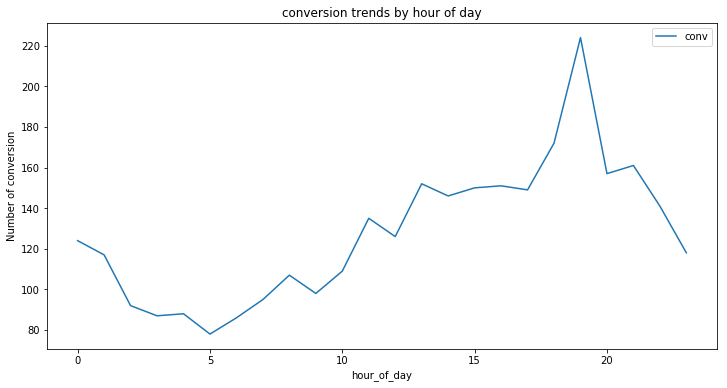

In [9]:
df_campaign_imp['hour_of_day'] = df_campaign_imp.timestamp.apply(lambda x: x.hour)
df_campaign_imp.groupby('hour_of_day').agg({'conv':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of conversion')
plt.title('conversion trends by hour of day');

as we can see, the highest number where people convert after seeing the impression is at hour 19 with value equals to 224 and the lowest is at hour 5 with value equals to 78.<br>
it seems a useful feature to use for predicting the target feature (conv feature).



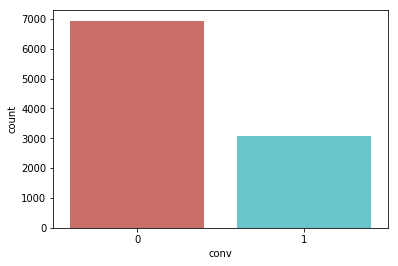


0    0.6937
1    0.3063
Name: conv, dtype: float64


In [10]:
info=Information()
info.convDistribution(pd_data)

we define the metric CTR as the number of conversions advertisers receive on their ads per number of impressions<br>
as we can see the number of people who convert after seeing an impression is approximately 30% and the number of people who didn't convert after seeing an impression is approximately 70%.<br>
the data here not equally distributed for the two classes of the conv (0 and 1) and this may affect negatively the performance of the model.

distribution of the feature hour_of_day :

4     0.0472
11    0.0460
12    0.0451
1     0.0439
22    0.0427
23    0.0426
9     0.0424
19    0.0423
0     0.0423
13    0.0418
6     0.0418
3     0.0418
14    0.0417
18    0.0413
5     0.0408
15    0.0408
8     0.0408
21    0.0405
10    0.0402
16    0.0401
7     0.0397
17    0.0391
2     0.0377
20    0.0374
Name: hour_of_day, dtype: float64

click through rate for each class of the feature hour_of_day :

for value: 0,  click through rate: 29.314420803782504 %
for value: 1,  click through rate: 26.65148063781321 %
for value: 2,  click through rate: 24.40318302387268 %
for value: 3,  click through rate: 20.813397129186605 %
for value: 4,  click through rate: 18.64406779661017 %
for value: 5,  click through rate: 19.11764705882353 %
for value: 6,  click through rate: 20.574162679425836 %
for value: 7,  click through rate: 23.929471032745592 %
for value: 8,  click through rate: 26.225490196078432 %
for value: 9,  click through rate: 23.11320754

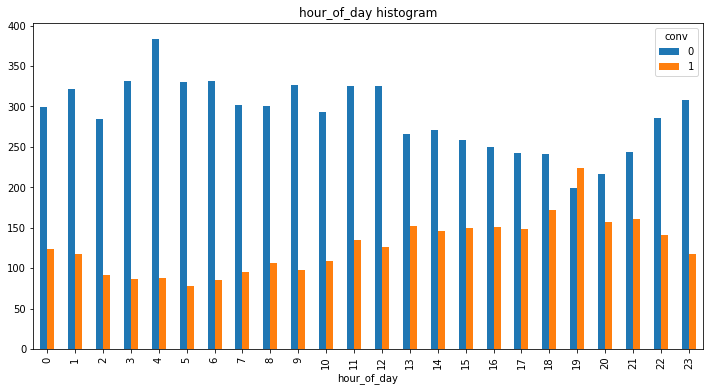

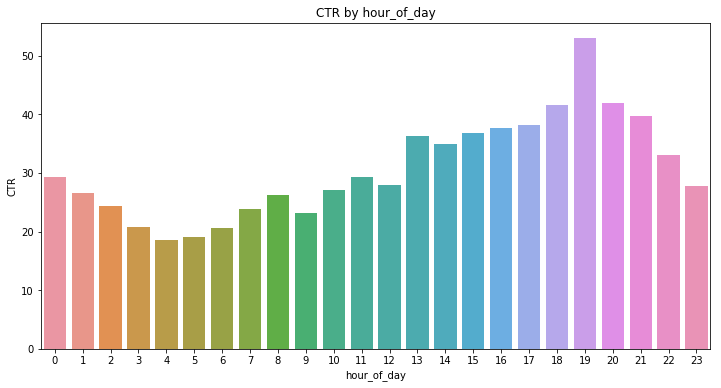

In [11]:
info.histVisualize(pd_data,'hour_of_day')

as we can see the highest number of CTR happens at hour 19, and this is the time where we have the highest number of people who convert after seeing the ad impression.

distribution of the feature resp_cr :

7.0     0.0992
9.0     0.0968
8.0     0.0959
3.0     0.0948
1.0     0.0947
6.0     0.0940
10.0    0.0935
5.0     0.0933
2.0     0.0928
4.0     0.0921
11.0    0.0529
Name: resp_cr, dtype: float64

click through rate for each class of the feature resp_cr :

for value: 1.0,  click through rate: 30.20063357972545 %
for value: 2.0,  click through rate: 30.926724137931032 %
for value: 3.0,  click through rate: 29.430379746835445 %
for value: 4.0,  click through rate: 32.24755700325733 %
for value: 5.0,  click through rate: 30.010718113612008 %
for value: 6.0,  click through rate: 31.914893617021278 %
for value: 7.0,  click through rate: 31.149193548387093 %
for value: 8.0,  click through rate: 30.552659019812307 %
for value: 9.0,  click through rate: 29.855371900826444 %
for value: 10.0,  click through rate: 31.336898395721924 %
for value: 11.0,  click through rate: 28.35538752362949 %


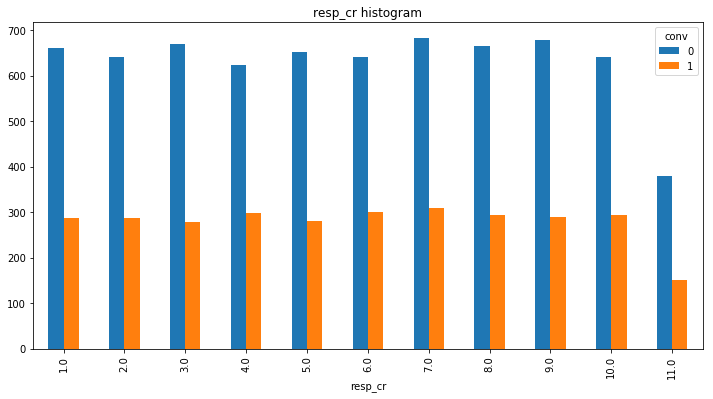

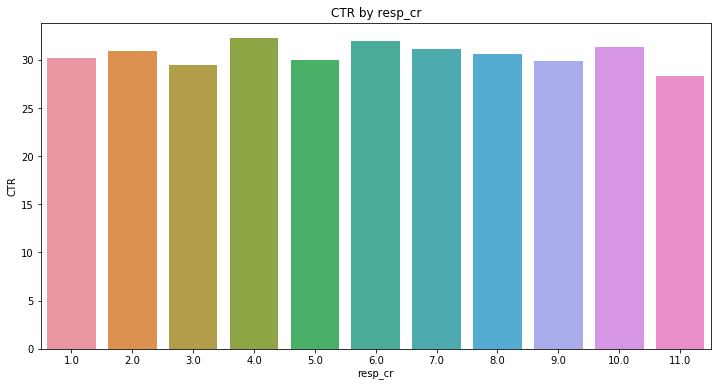

In [12]:
info.histVisualize(pd_data,'resp_cr')

the distribution of the resp_cr feature is almost uniform.

the resp_cr equals to 4 has the highest value of the CTR (approximately 32.24%).
the unknown class of the resp_cr (equal to 11) has the lowest value of the CTR.
this feature can give us information to predict whether people who see the impression will convert or not 

distribution of the feature resp_c :

2    0.3375
1    0.3351
3    0.3274
Name: resp_c, dtype: float64

click through rate for each class of the feature resp_c :

for value: 1,  click through rate: 37.00387943897344 %
for value: 2,  click through rate: 30.31111111111111 %
for value: 3,  click through rate: 24.434941967012826 %


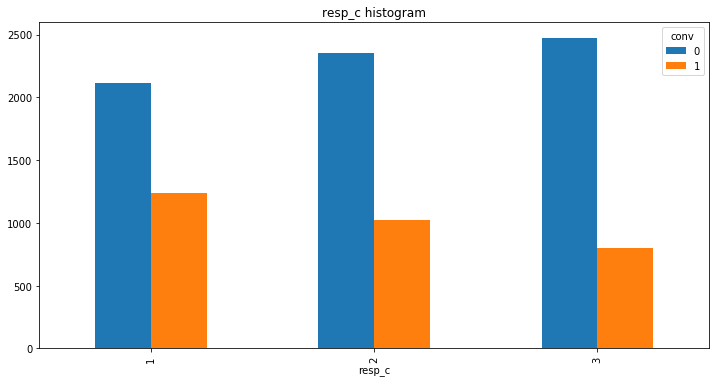

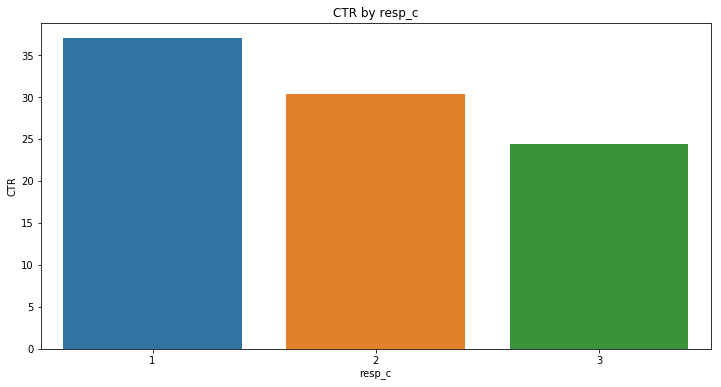

In [13]:
info.histVisualize(pd_data,'resp_c')

the distribution is almost uniform

as we can see, when resp_c ==1 the CTR is the highest and it's equal approximately to 37%, it seems that this feature is imporatant to predict whether the people who see the impression will convert or not.

distribution of the feature dev_os :

4    0.5051
5    0.4949
Name: dev_os, dtype: float64

click through rate for each class of the feature dev_os :

for value: 4,  click through rate: 19.679271431399723 %
for value: 5,  click through rate: 41.80642554051324 %


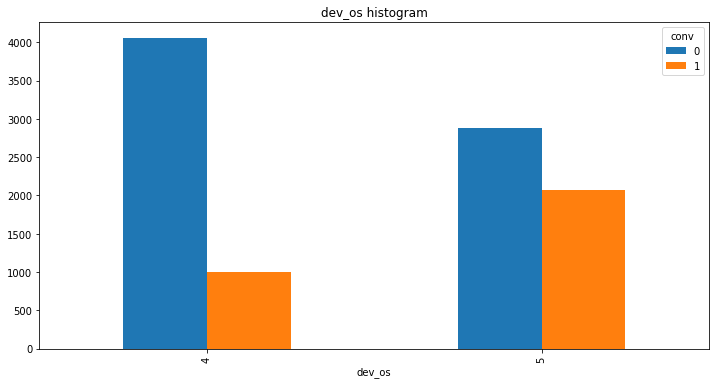

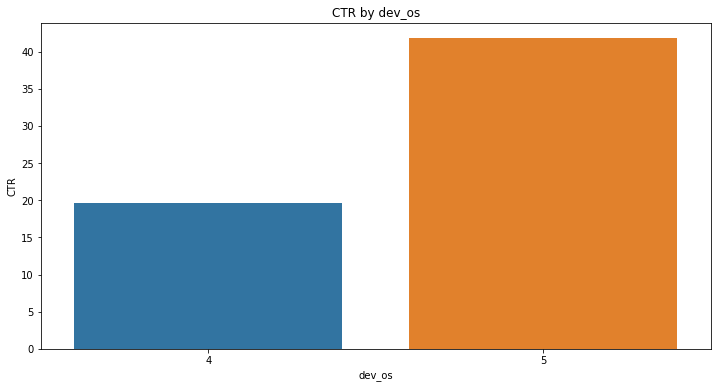

In [14]:
info.histVisualize(pd_data,'dev_os')

the people that use the os where dev_os==4 has the highest number of impressions but the lowest CTR.
this feature may help to get a good prediction.

distribution of the feature dev_app :

7     0.3374
22    0.3346
9     0.3280
Name: dev_app, dtype: float64

click through rate for each class of the feature dev_app :

for value: 7,  click through rate: 30.94250148192057 %
for value: 9,  click through rate: 30.70121951219512 %
for value: 22,  click through rate: 30.245068738792586 %


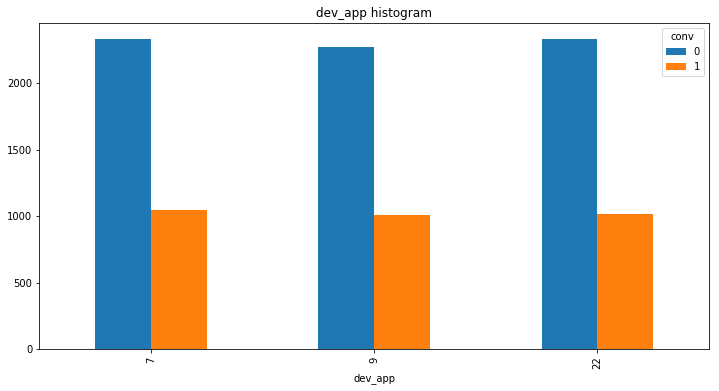

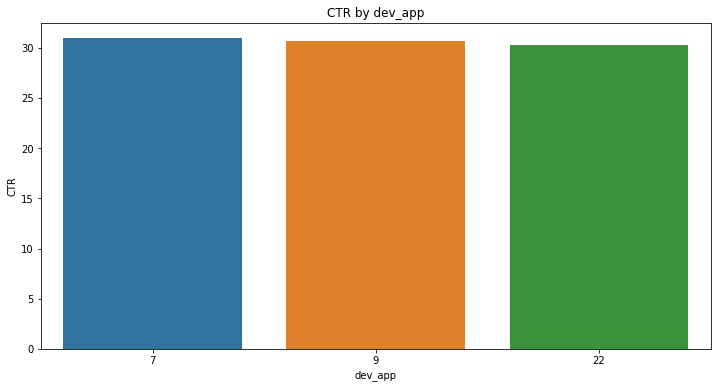

In [15]:
info.histVisualize(pd_data,'dev_app')

this feature has 3 classes [7,9,8] and they're equally distributed. their CTR also is almost the same.
this feature seems not very good to make a good prediction.

distribution of the feature PARENT :

0    0.5786
1    0.4214
Name: PARENT, dtype: float64

click through rate for each class of the feature PARENT :

for value: 0,  click through rate: 26.425855513307983 %
for value: 1,  click through rate: 36.40246796392976 %


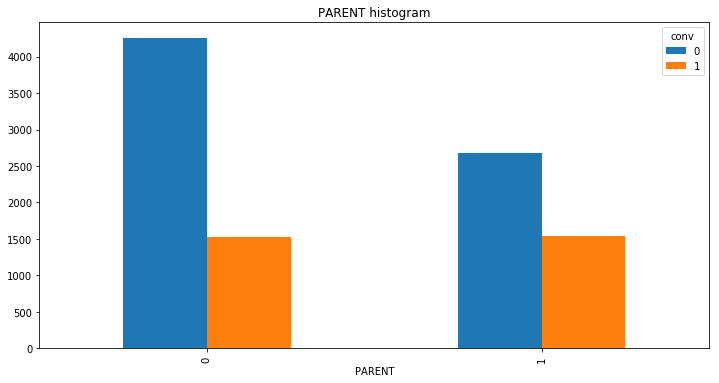

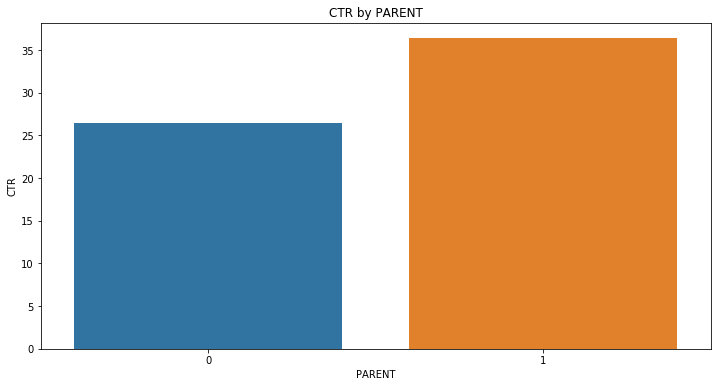

In [16]:
info.histVisualize(pd_data_join,'PARENT')

this seems to be a good feature for better prediction

we can do the same analysis for the other feature to see if this feature can help or not to get better prediction

In [17]:
df_campaign_imp.resp_oi.unique()

array([8])

we have just one value for the feature resp_cr, so this feature can give us no information that help to do predicition, so we can drop it.

In [21]:
#create train and test data
from sklearn.model_selection import train_test_split
pd_data_equal_dist=preprocess.makeEqualDist(pd_data_join)
X_train, X_test, y_train, y_test = train_test_split(pd_data_join.loc[:, pd_data_join.columns != 'conv'], pd_data_join.conv, test_size=0.3, random_state=4)


<h2>3.Machine learning </h2>

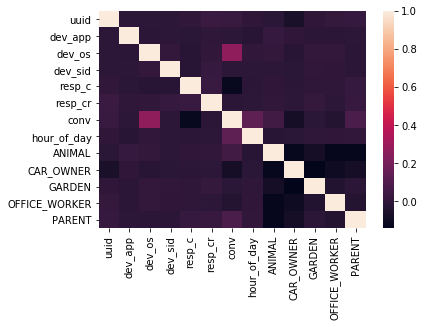

In [19]:
plotCorrelation(pd_data_equal_dist)

the data here is uncorrelated and this is good because each feature can give us a new information to predict the conv value 

In [20]:
#train lightgbm model
model=MachineLearning('lightgbm')
model.train(X_train,y_train)

start training lightgbm model...
[1]	valid_0's binary_logloss: 0.602252
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.600653
[3]	valid_0's binary_logloss: 0.596861
[4]	valid_0's binary_logloss: 0.592599
[5]	valid_0's binary_logloss: 0.589643
[6]	valid_0's binary_logloss: 0.585847
[7]	valid_0's binary_logloss: 0.583551
[8]	valid_0's binary_logloss: 0.580879
[9]	valid_0's binary_logloss: 0.57881
[10]	valid_0's binary_logloss: 0.57646
[11]	valid_0's binary_logloss: 0.574434
[12]	valid_0's binary_logloss: 0.5728
[13]	valid_0's binary_logloss: 0.570848
[14]	valid_0's binary_logloss: 0.570515
[15]	valid_0's binary_logloss: 0.569335
[16]	valid_0's binary_logloss: 0.567316
[17]	valid_0's binary_logloss: 0.565952
[18]	valid_0's binary_logloss: 0.564427
[19]	valid_0's binary_logloss: 0.563218
[20]	valid_0's binary_logloss: 0.562116
[21]	valid_0's binary_logloss: 0.56137
[22]	valid_0's binary_logloss: 0.560504
[23]	valid_0's binary_logloss: 0.55918

In [21]:
p=model.predict(X_test)
evaluate(y_pred=p,y_act=y_test)

Confusion Matrix:

[[1932   99]
 [ 839  130]]

 classification Report:

             precision    recall  f1-score   support

          0       0.95      0.70      0.80      2771
          1       0.13      0.57      0.22       229

avg / total       0.89      0.69      0.76      3000



in this case, using **accuracy** is not really good metric because the number of the people who didn't convert when seeing an impression(conv==0) is greater than the people who convert when seeing an impression (conv==1), so we can get a good accuracy if we predict all the test as 0. so, we choose as a metric to evaluate the performance of our model **f1_score**, this is good to get a better understanding of our prediction.<br><br>
as we can see, we get as f1_score for the class 0 equal to 0.80 (this means that our model predict well whether the conv is equal to 0), however, f1_score for the class 1 is very low (0.22), so this model hasn't a good performance.
<br>
the model here is biased, because the distribution of the data through the two classes is not equally distributed (the examples where conv==0 >> the examples where conv==1).
<br> as a solution to this problem we can create another trainig data that has equally distribution of the conv columns by the method **makeEqualDist()** of the class **PreprocessingData**


In [22]:
#split the equally distributed dataset to train/test data
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(pd_data_equal_dist.loc[:, pd_data_equal_dist.columns != 'conv'], pd_data_equal_dist.conv, test_size=0.33, random_state=42)


In [23]:
#train lightgbm model using the train data extracted from the equally distributed dataset
model1=MachineLearning('lightgbm')
model1.train(X_train_e,y_train_e)

start training lightgbm model...
[1]	valid_0's binary_logloss: 0.689031
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.686411
[3]	valid_0's binary_logloss: 0.682232
[4]	valid_0's binary_logloss: 0.678172
[5]	valid_0's binary_logloss: 0.674261
[6]	valid_0's binary_logloss: 0.670551
[7]	valid_0's binary_logloss: 0.667027
[8]	valid_0's binary_logloss: 0.663508
[9]	valid_0's binary_logloss: 0.660384
[10]	valid_0's binary_logloss: 0.658252
[11]	valid_0's binary_logloss: 0.657078
[12]	valid_0's binary_logloss: 0.655768
[13]	valid_0's binary_logloss: 0.65479
[14]	valid_0's binary_logloss: 0.653409
[15]	valid_0's binary_logloss: 0.652003
[16]	valid_0's binary_logloss: 0.650945
[17]	valid_0's binary_logloss: 0.649586
[18]	valid_0's binary_logloss: 0.649071
[19]	valid_0's binary_logloss: 0.647777
[20]	valid_0's binary_logloss: 0.646009
[21]	valid_0's binary_logloss: 0.644897
[22]	valid_0's binary_logloss: 0.64401
[23]	valid_0's binary_logloss: 0.64

In [24]:
p=model1.predict(X_test_e)
evaluate(y_pred=p,y_act=y_test_e)


Confusion Matrix:

[[639 342]
 [368 673]]

 classification Report:

             precision    recall  f1-score   support

          0       0.65      0.63      0.64      1007
          1       0.65      0.66      0.65      1015

avg / total       0.65      0.65      0.65      2022



as we can see  the f1_score of the class 0 gets better (0.22--> 0.65) and also the precision (0.13-->0.65), but the f1_score of the class 0 gets worse

now we're going to try another model, called xgboost.

In [25]:
model2=MachineLearning('xgboost')
model2.train(X_train,y_train)

start training xgboost model
[0]	train-logloss:0.673291	test-logloss:0.671675
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 800 rounds.


/mnt/workspace/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1000]	train-logloss:0.543714	test-logloss:0.53863
Stopping. Best iteration:
[813]	train-logloss:0.544465	test-logloss:0.537921



Confusion Matrix:

[[1858  173]
 [ 730  239]]

 classification Report:

             precision    recall  f1-score   support

          0       0.91      0.72      0.80      2588
          1       0.25      0.58      0.35       412

avg / total       0.82      0.70      0.74      3000



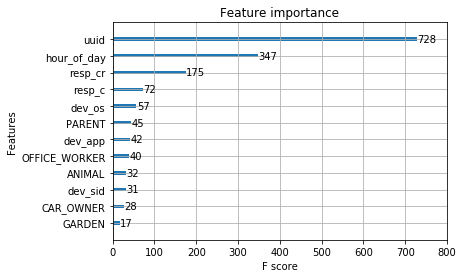

In [26]:

p=model2.predict(X_test)
evaluate(y_pred=p,y_act=y_test)
model2.plot_importance()

we can noticed here the three best features is uuid, hour_of_day and resp_cr<br>
regarding the confusion matrix, we can say that our model has a lot of mistake for the class 1, the model predict 730 examples as a 0 instead of 1 and 239 correct.
<br> now we're trying to use the equally distributed dataset

In [27]:
model3=MachineLearning('xgboost')
model3.train(X_train_e,y_train_e)

start training xgboost model
[0]	train-logloss:0.685662	test-logloss:0.68628
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 800 rounds.


/mnt/workspace/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1000]	train-logloss:0.599868	test-logloss:0.628048
[2000]	train-logloss:0.589937	test-logloss:0.622092
[3000]	train-logloss:0.582331	test-logloss:0.617335
[4000]	train-logloss:0.57603	test-logloss:0.613467
[4999]	train-logloss:0.570013	test-logloss:0.609985


Confusion Matrix:

[[685 296]
 [334 707]]

 classification Report:

             precision    recall  f1-score   support

          0       0.70      0.67      0.69      1019
          1       0.68      0.70      0.69      1003

avg / total       0.69      0.69      0.69      2022



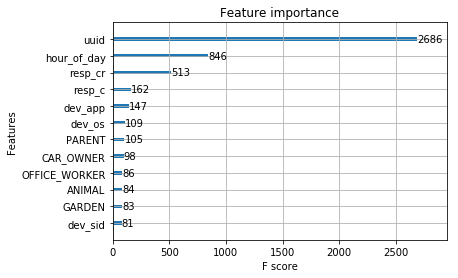

In [28]:

p=model3.predict(X_test_e)
evaluate(y_pred=p,y_act=y_test_e)
model3.plot_importance()

in general, training the model using equally distributed dataset can improve model performance and especially good prediction of the class 1. here for the target (conv) 1 we get 707 correct answers out of 1041 and a f1_score of 0.69. 

In [29]:
model_svm=MachineLearning('svm')
model_svm.train(X_train_e,y_train_e)

In [30]:
y_pred = model_svm.predict(X_test_e)
evaluate(y_test_e,y_pred)

Confusion Matrix:

[[578 403]
 [324 717]]

 classification Report:

             precision    recall  f1-score   support

          0       0.59      0.64      0.61       902
          1       0.69      0.64      0.66      1120

avg / total       0.64      0.64      0.64      2022



f1_score(0) == 0.61<br>
f1_score(1) ==0.66

In [31]:
model4=MachineLearning('logisticRegression')
model4.train(X_train_e,y_train_e)

In [32]:
y_pred = model4.predict(X_test_e)

In [33]:
evaluate(y_test_e,y_pred)

Confusion Matrix:

[[633 348]
 [375 666]]

 classification Report:

             precision    recall  f1-score   support

          0       0.65      0.63      0.64      1008
          1       0.64      0.66      0.65      1014

avg / total       0.64      0.64      0.64      2022



f1_score(0)==0.64<br>
f1_score(1)==0.65

<h3> combined model by xgboost</h3>

<h4>the general idea here:</h4>
<h5>1-validation startegy</h5>

we split the equally distributed dataset into 3 subset:<br>
-train: to train the base models<br>
-val1:to validate the base model and is used to train the xgboost model of the second stage<br>
-val2:to validate the combined model which no model used to train <br>
the general idea here is to be able to validate the performance of the combined model at each stage.

<br>this approach is two-stage approach:<br>
**first stage:** train some base model using the equally distributed dataset<br>
-lightgbm<br>
-xgboost<br>
-logisticRegression<br>
-svm<br>
**second stage:** this stage aims to combine the previous models by using xgboost trained on the generated dataframe from the first stage.
<br>the trainig data used to train the second stage is built as following:
<table>
    <tr>
        <td>lightgbm</td>
        <td>logisticRegression</td>
        <td>svm</td>
        <td>xgboost</td>
    </tr>
     <tr>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>
     <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
     <tr>
        <td>0</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>

</table>


In [35]:
X_train_c, y_train_c, X_val1_c, X_val2_c, y_val1_c, y_val2_c=validationStrategy(pd_data_equal_dist)

In [43]:
cobMo=CombinedModel(X_train_c, y_train_c, X_val1_c, y_val1_c)


start training xgboost model
[0]	train-logloss:0.68641	test-logloss:0.686582
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 800 rounds.


/mnt/workspace/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1000]	train-logloss:0.597176	test-logloss:0.636518
Stopping. Best iteration:
[212]	train-logloss:0.616519	test-logloss:0.629255

start training lightgbm model...
[1]	valid_0's binary_logloss: 0.689068
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.687955
[3]	valid_0's binary_logloss: 0.684517
[4]	valid_0's binary_logloss: 0.680433
[5]	valid_0's binary_logloss: 0.677876
[6]	valid_0's binary_logloss: 0.675334
[7]	valid_0's binary_logloss: 0.672184
[8]	valid_0's binary_logloss: 0.6696
[9]	valid_0's binary_logloss: 0.666855
[10]	valid_0's binary_logloss: 0.66549
[11]	valid_0's binary_logloss: 0.663223
[12]	valid_0's binary_logloss: 0.66127
[13]	valid_0's binary_logloss: 0.658762
[14]	valid_0's binary_logloss: 0.657477
[15]	valid_0's binary_logloss: 0.656647
[16]	valid_0's binary_logloss: 0.654612
[17]	valid_0's binary_logloss: 0.652495
[18]	valid_0's binary_logloss: 0.650846
[19]	valid_0's binary_logloss: 0.649729
[20]	valid_0's binary_loglo

In [46]:
X_val2_c_.shape

(981, 4)

In [49]:
from time import time
start=time()
ls_model=cobMo.getLsModel()#get the list of the trained base models
X_val2_c_=dataGenSecondLevel(ls_model,X_val2_c,y_val2_c) #generate the validation data for the second stage
model_ens=cobMo.getCombinedModel()#get the trained combined model
p=model_ens.predict(X_val2_c_)
print('inference time:  {}'.format(time()-start))
evaluate(p,y_val2_c)

inference time:  0.16305088996887207
Confusion Matrix:

[[303 160]
 [180 338]]

 classification Report:

             precision    recall  f1-score   support

          0       0.65      0.63      0.64       483
          1       0.65      0.68      0.67       498

avg / total       0.65      0.65      0.65       981



In [45]:
for model in ls_model:
    print('---------------------{}--------------------'.format(model.getModelName()))
    p=model.predict(X_val2_c)
    evaluate(p,y_val2_c)

---------------------xgboost--------------------
Confusion Matrix:

[[324 178]
 [159 320]]

 classification Report:

             precision    recall  f1-score   support

          0       0.65      0.67      0.66       483
          1       0.67      0.64      0.66       498

avg / total       0.66      0.66      0.66       981

---------------------lightgbm--------------------
Confusion Matrix:

[[293 167]
 [190 331]]

 classification Report:

             precision    recall  f1-score   support

          0       0.64      0.61      0.62       483
          1       0.64      0.66      0.65       498

avg / total       0.64      0.64      0.64       981

---------------------logisticRegression--------------------
Confusion Matrix:

[[305 184]
 [178 314]]

 classification Report:

             precision    recall  f1-score   support

          0       0.62      0.63      0.63       483
          1       0.64      0.63      0.63       498

avg / total       0.63      0.63      0.63    

regarding the performance of each base model and the performance of the combined model, we can notice that the combined model has the best performance:<br>
f1_score(0)==0.66
<br>f1_score(1)==0.67

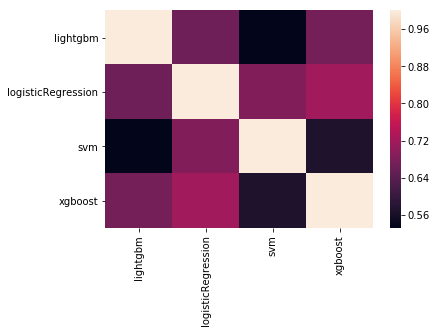

In [41]:
plotCorrelation(cobMo.getDataGenTrain())

we can notice by displaying the correlation between the prediction of each model, that the 3 models are uncorrelated and this is good for better prediction and performance of the combined model. 

<h1> Further work:</h1>

the next steps to do to improve our model is:<br>
-tune the hyperparameters of each used model and this by for example doing grid search. Grid search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.<br><br>
-Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.<br><br>
-add some **artificial feature**, for example : for each user we can add the feature that count: how many time a user see an impression, how many time a user see an impression and convert, how many time a user see an impression and don't convert...
